In [1]:
import numpy as np
import sep

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = [10., 8.]

## Image Display
We will first define the F105W band image of the Hubble Ultra Deep Field from the FITS file and read it into the notebook.

In [3]:
#define file name
fdata_F105W = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
#read in data
hdu_2 = fits.open(fdata_F105W)
#get image data
data_2 = hdu_2[0].data

Display the contents of the image.

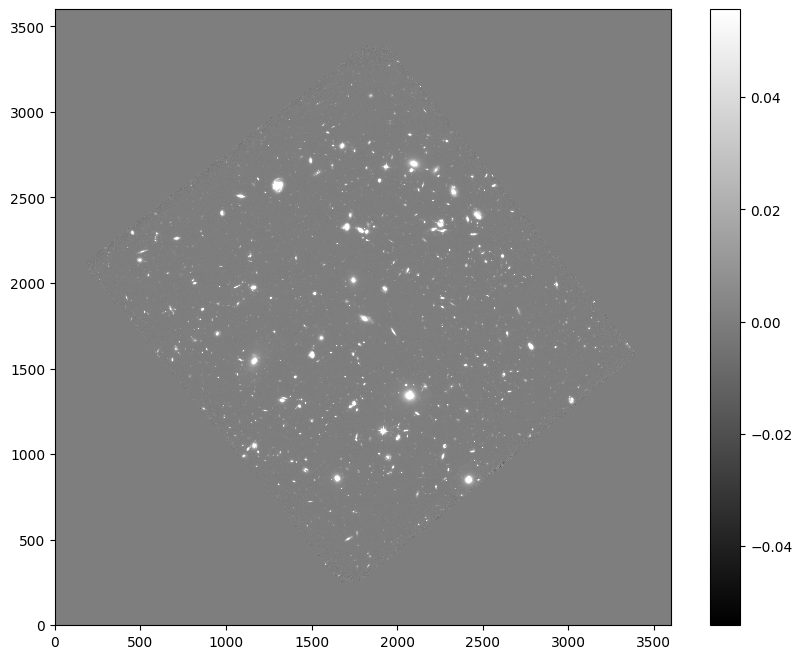

In [4]:
#show the image
m, s = np.mean(data_2), np.std(data_2)
plt.imshow(data_2, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig('HUDF_Image.png',bbox_inches="tight",dpi=600)

## Background Subtraction
We use SEP to subtract the background to detect sources.

In [5]:
data = data_2.byteswap(inplace=True).newbyteorder()

In [6]:
#measures a spatially varying background on the image.
bkg = sep.Background(data)

In [7]:
#get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [8]:
#evaulate background as 2-d array, same size as the original image
bkg_image = bkg.back()
#bkg_image = np.array(bkg) is an equivlent to the line above

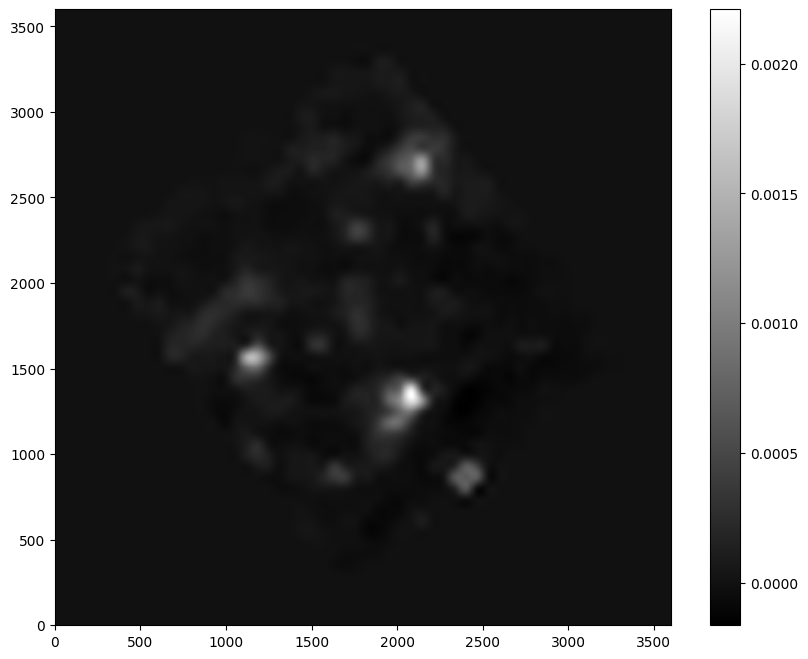

In [9]:
#show the background
plt.imshow(bkg_image, interpolation='nearest',cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('HUDF_Background_Image.png',bbox_inches="tight",dpi=600)

In [10]:
#evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

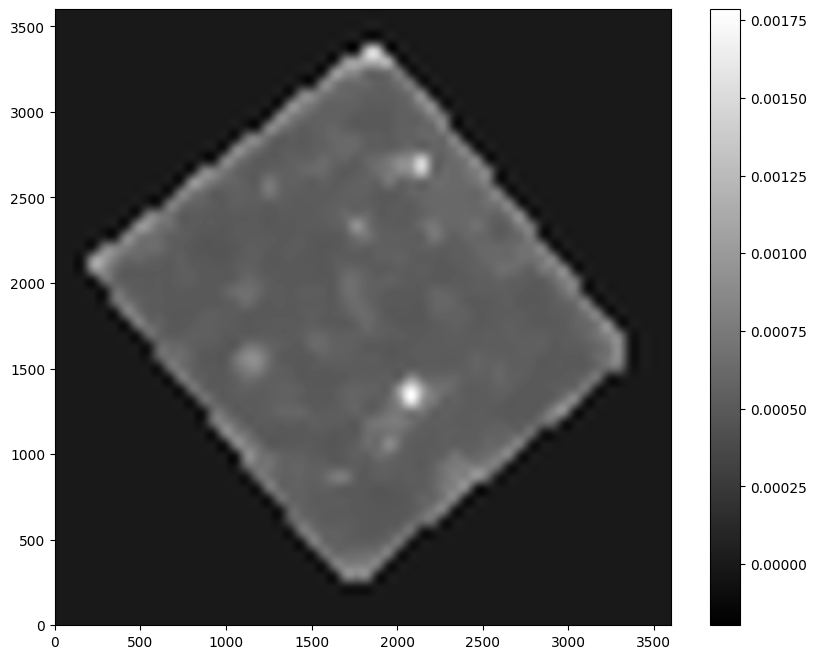

In [11]:
#show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('HUDF_Background_Subtract.png',bbox_inches="tight",dpi=600)

In [12]:
#subtract the background
data_sub = data - bkg

## Object Detection
With the background subtracted, we can now run object detection on the background-subtracted data. The detection threshold at a constant value of 1.5σ  where is the global background RMS.

In [13]:
objects = sep.extract(data_sub, 2.5, err=bkg.globalrms)

We define the amount of sources (objects) are detected in the image.

In [14]:
#how many objects were detected?
len(objects)

5266

With the number of objects detected, we will check where the detected objects are located.

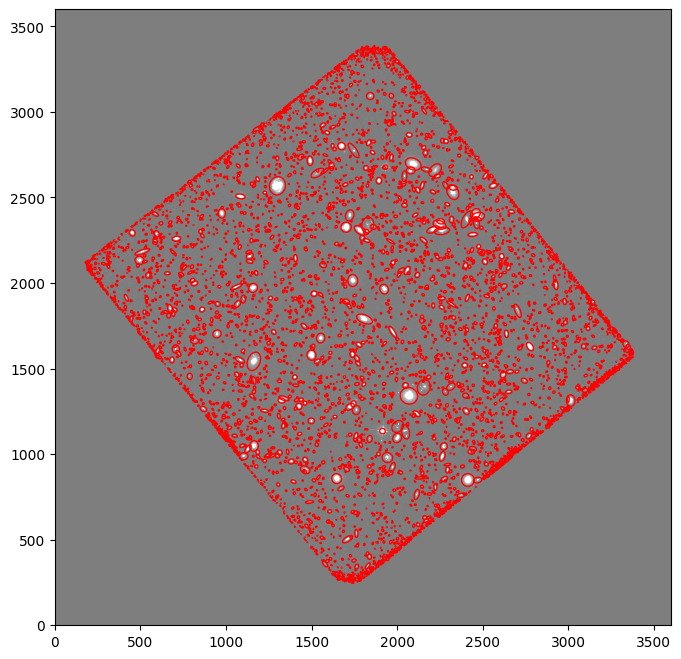

In [15]:
from matplotlib.patches import Ellipse

#plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse over each object detected
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('HUDF_Detection_Image.png',bbox_inches="tight",dpi=600)

## Aperture photometry
We will perform a simple circular aperture photometry with a 3 pixel radius at the location of each object.

In [16]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

In [17]:
#show the loccation for the first 10 objects 
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031392 +/- 0.177201
object 1: flux = 0.030707 +/- 0.175258
object 2: flux = 0.029780 +/- 0.172591
object 3: flux = 0.046358 +/- 0.215328
object 4: flux = 0.010736 +/- 0.103654
object 5: flux = 0.085722 +/- 0.292797
object 6: flux = 0.010265 +/- 0.101357
object 7: flux = 0.064379 +/- 0.253747
object 8: flux = 0.070986 +/- 0.266448
object 9: flux = 0.009351 +/- 0.096743


Mean of the fluxes is 0.5844441307650418.
Median of the fluxes is 0.05657099022886543.
Standard Deviation of the fluxes is 11.835813756627056.
The outlier is 807.3367860794068.
The number of deviations that the outlier lies from the mean is 68.16196659878402.


C:\Users\Hennessey\AppData\Local\Temp\ipykernel_3608\2039285677.py:16: RuntimeWarning: invalid value encountered in log10
  ax.hist(np.log10(flux), bins=20)


<function matplotlib.pyplot.show(close=None, block=None)>

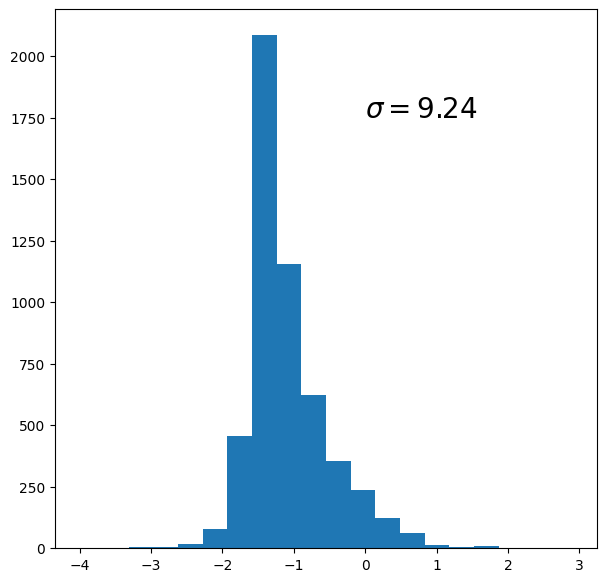

In [18]:
flux_mean = np.mean(flux)
flux_std = np.std(flux)
flux_median = np.median(flux)
flux_outlier = np.max(flux)

num_stds = ((flux_outlier - flux_mean) / flux_std)

print(f"Mean of the fluxes is {flux_mean}.")
print(f"Median of the fluxes is {flux_median}.")
print(f"Standard Deviation of the fluxes is {flux_std}.")
print(f"The outlier is {flux_outlier}.")
print(f"The number of deviations that the outlier lies from the mean is {num_stds}.")

f, ax = plt.subplots(1,1, figsize=(7,7))
ax.text(0, 1750, r'$\sigma = 9.24$', color='0', fontsize=20)
ax.hist(np.log10(flux), bins=20)
plt.show

In [19]:
#define image data
fdata_F160W = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"
fdata_F125W = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
#read in data
hdu_3 = fits.open(fdata_F160W)
hdu_4 = fits.open(fdata_F125W)
#get image data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data

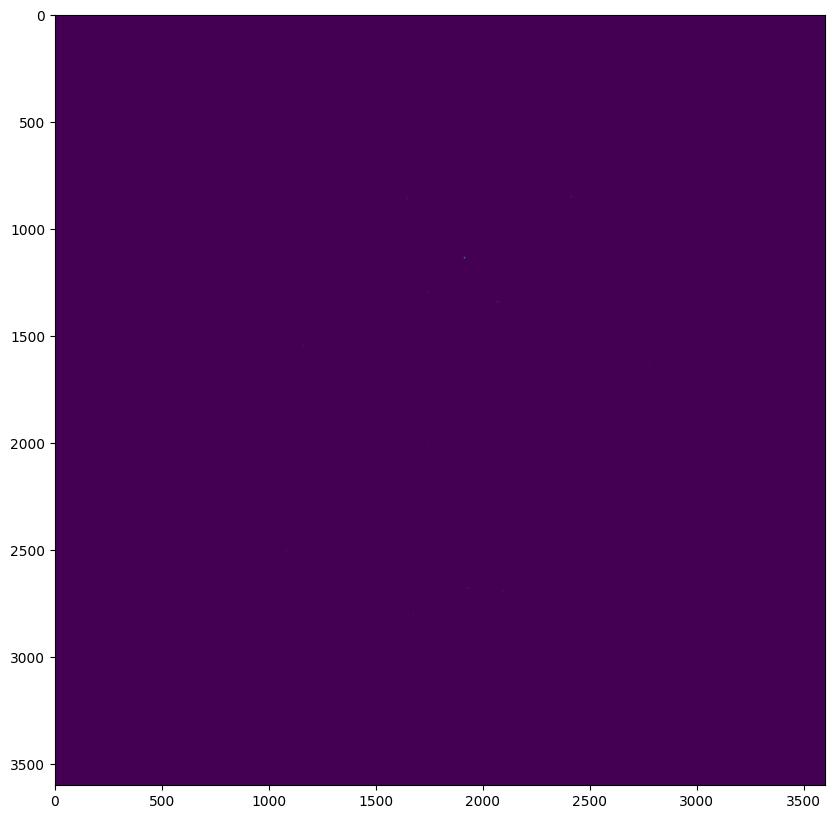

In [20]:
f = plt.figure(figsize=(10,10))
plt.imshow(data_3)

In [21]:
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m*100.)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp, vpmin, vpmax

In [22]:
def fits_quicklook(data,fnx=10,fny=10):
    f = plt.figure(figsize=(fnx,fny))
    pdata_tmp, vpmin, vpmax = rescale_image(data)
    plt.imshow(pdata_tmp,vmin=vpmin, vmax=vpmax)

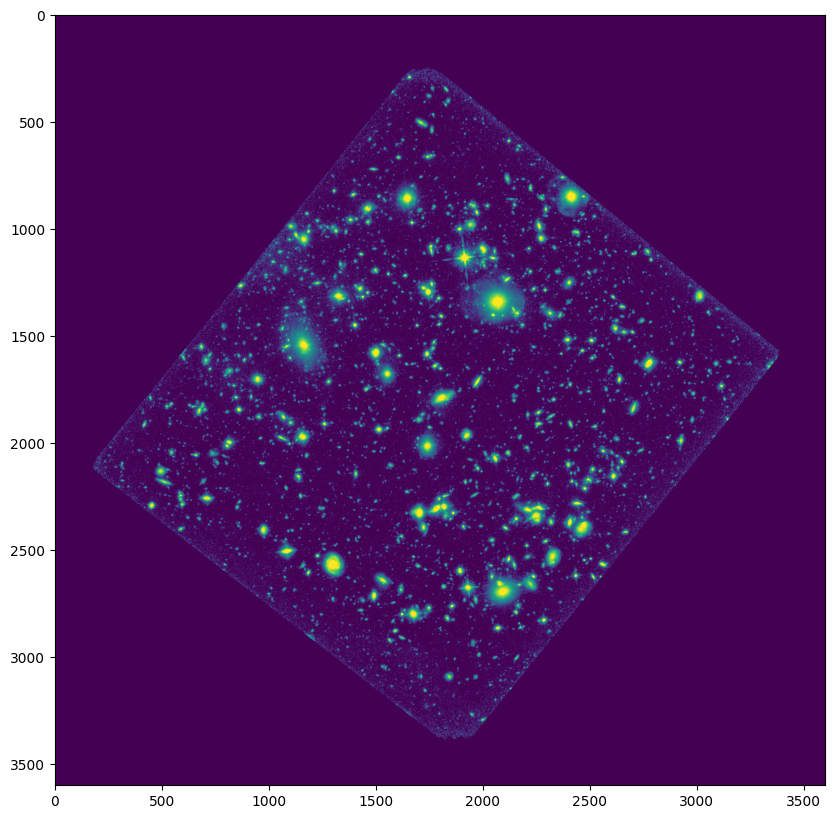

In [23]:
fits_quicklook(data_3)

In [24]:
data_2_res, d2min, d2max = rescale_image(data_2)
data_3_res, d3min, d3max = rescale_image(data_3)
data_4_res, d4min, d4max = rescale_image(data_4)

C:\Users\Hennessey\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Hennessey\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Hennessey\AppData\Local\Temp\ipykernel_3608\783633848.py:8: RuntimeWarning: divide by zero encountered in log10
  pdata_tmp = np.log10(pdata_tmp)
C:\Users\Hennessey\AppData\Local\Temp\ipykernel_3608\783633848.py:8: RuntimeWarning: invalid value encountered in log10
  pdata_tmp = np.log10(pdata_tmp)


In [25]:
data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max] = d2max
data_3_res[data_3_res<d2min] = d3min
data_3_res[data_3_res>d2max] = d3max
data_4_res[data_4_res<d2min] = d4min
data_4_res[data_4_res>d2max] = d4max

In [26]:
rgb = np.zeros((data_2_res.shape[0], data_2_res.shape[1],3))
rgb[:,:,0] = (data_2_res-d2min)/(d2max-d2min)
rgb[:,:,1] = (data_3_res-d3min)/(d3max-d3min)
rgb[:,:,2] = (data_4_res-d4min)/(d3max-d4min)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


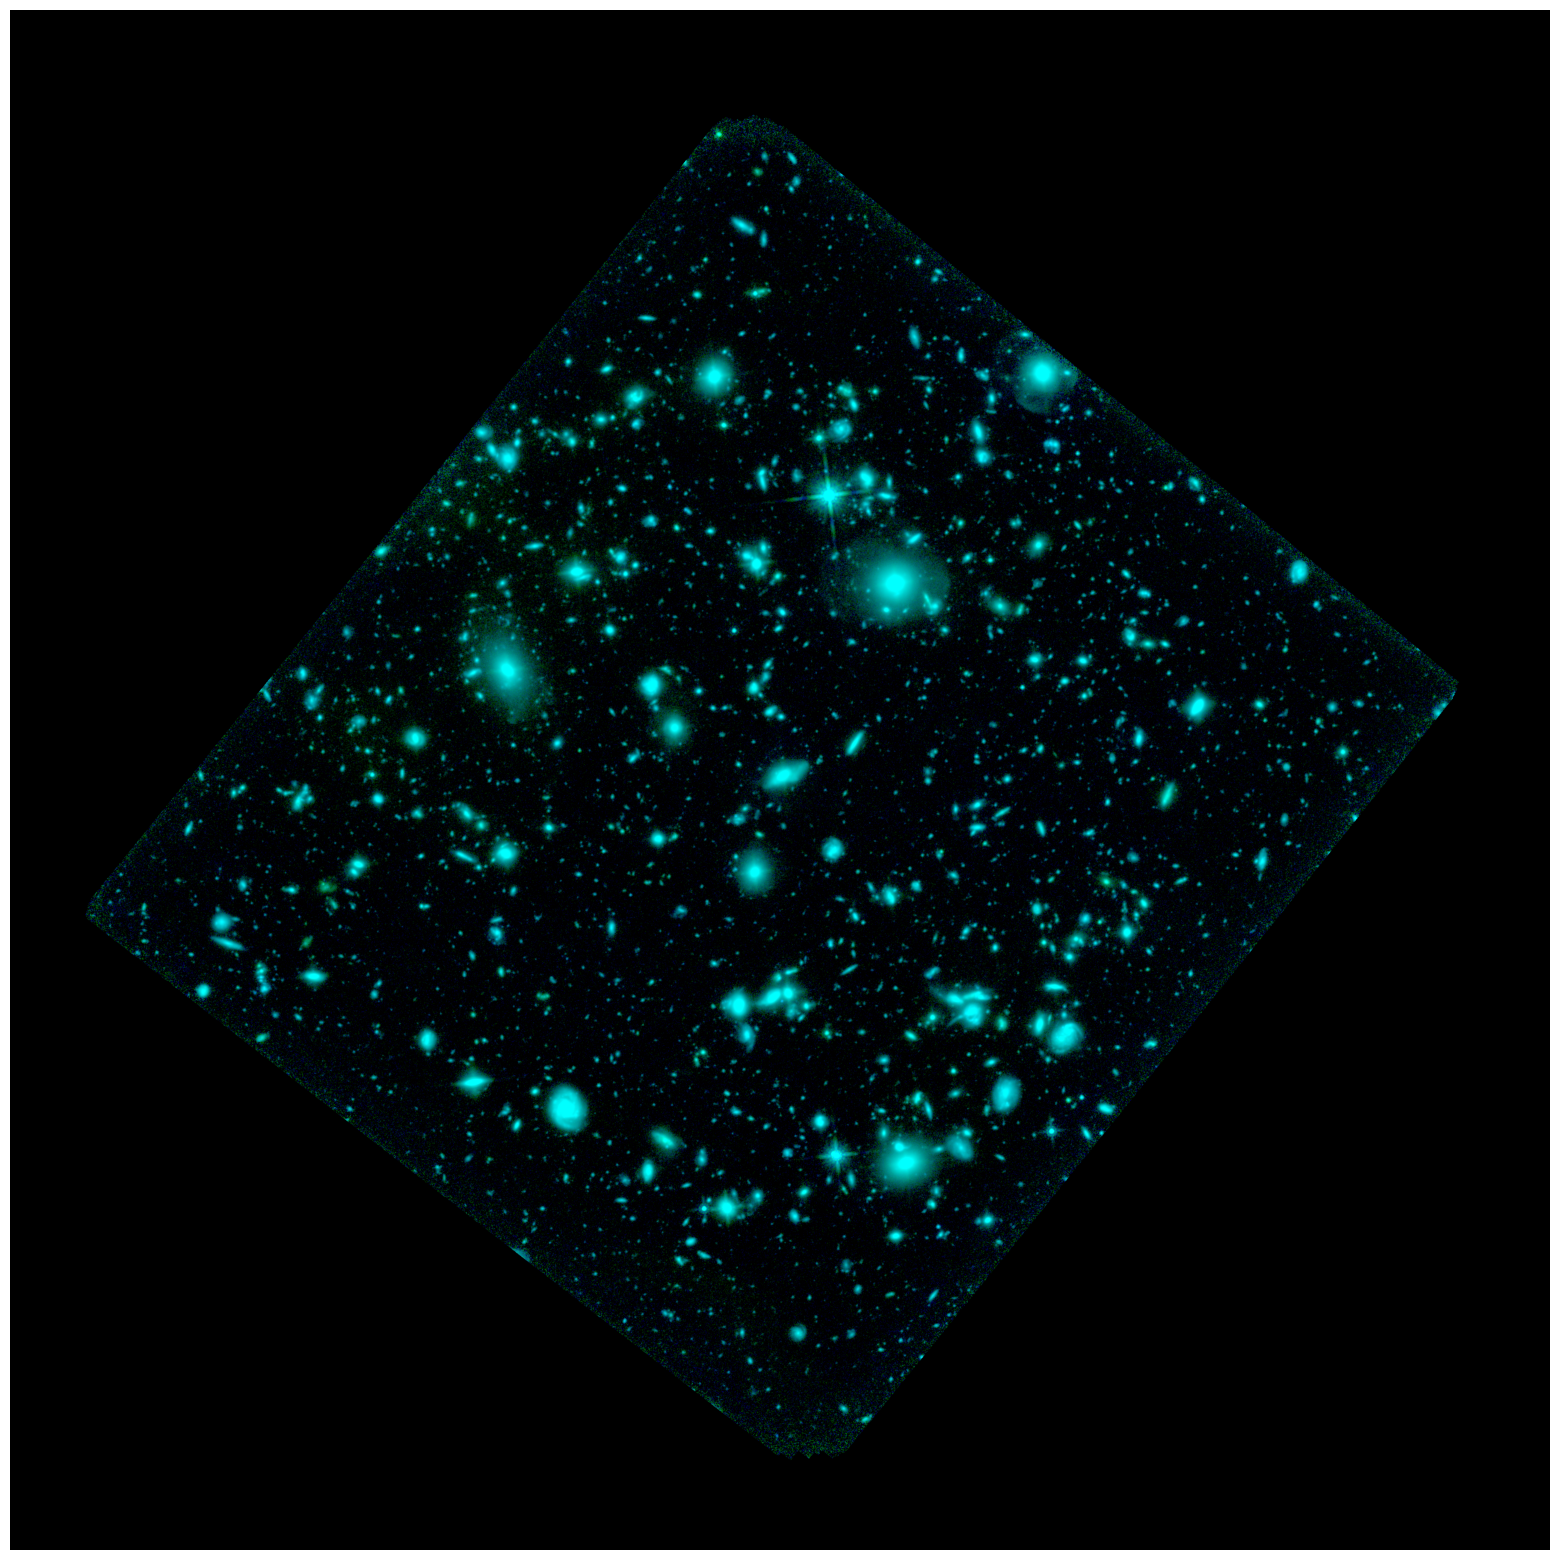

In [28]:
f, ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)
plt.savefig('HUDF_color_image.png',bbox_inches='tight',pad_inches=0, dpi=600)